# Modeling Credit Risk with Lending Club data

### Outline

1. Business problem and summary of results
2. Data import.
3. Data preprocessing.
4. EDA.
5. Sample split, missing values and feature engineering.
6. Modeling.
7. Interpretation of the results.
8. Business implications.

#### Objective: Predict delinquency of a borrower
#### Metric: Precision at 20% Recall.

#### Business problem




#### Notes:

One big question about this data is which features are available at the origination time and are never updated afterwards. It seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.
I will use only features, known before loan issuance.

### Business Problem

### Objective

### Summary of Results

## 2. Data import

In [202]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys, re
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [203]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [204]:
time0 = time.time()

with open('../input/lc-sample850k/LCLoans_sample850k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['id', 'loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status', 
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc', 'bc_open_to_buy', 'mo_sin_rcnt_rev_tl_op', 'num_actv_rev_tl', 'num_op_rev_tl', 'total_rev_hi_lim',               
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint',
 'total_bal_ex_mort', 'tot_coll_amt', 'tax_liens', 'percent_bc_gt_75', 'pct_tl_nvr_dlq', 
 'open_rv_12m', 'open_il_12m', 'num_tl_90g_dpd_24m', 'num_tl_30dpd', 'num_tl_120dpd_2m',
 'num_accts_ever_120_pd',
 'recoveries', 'total_rec_prncp', 'total_rec_int']

df = df[features_tokeep]
dc.collect()

recoveries = df[df.loan_status.isin(['Charged Off', 'Default'])][[
    'id', 'loan_status', 'recoveries', 'loan_amnt', 'int_rate', 'total_rec_prncp', 'total_rec_int']]

df.drop(columns = ['recoveries', 'total_rec_prncp', 'total_rec_int'], inplace=True)
# this removes all features, not known to investors ex ante.

df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later

df.issue_d = df.issue_d.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
#df = df[df.year_issued.isin([2018])]
    
#df = df.sample(200000, random_state=1)
df.reset_index(inplace=True, drop=True)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(851133, 68)

1.526012659072876

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued
0,1077175,Fully Paid,2400.0,2400.0,2400.0,36.0,15.96,84.330002,2011-12-01,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10+ years,RENT,12252.0,606xx,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nov-2001,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
1,1071795,Charged Off,5600.0,5600.0,5600.0,60.0,21.28,152.389999,2011-12-01,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4 years,OWN,40000.0,958xx,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Apr-2004,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
2,1069908,Fully Paid,12000.0,12000.0,12000.0,36.0,12.69,402.540009,2011-12-01,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10+ years,OWN,75000.0,913xx,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Oct-1989,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
3,1069866,Fully Paid,3000.0,3000.0,3000.0,36.0,9.91,96.680000,2011-12-01,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3 years,RENT,15000.0,606xx,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jul-2003,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,7323.0,43.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0
4,1065775,Fully Paid,10000.0,10000.0,10000.0,36.0,15.27,347.980011,2011-12-01,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4 years,RENT,42000.0,921xx,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,Oct-1998,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,24043.0,70.2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0


## 3. Data preprocessing

In [205]:
### feature description:

#f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
#f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
#display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])

In [206]:
# remove some very rarae loan types:

df = df[~df.purpose.isin(['educational', 'renewable_energy', 'wedding'])]
df.purpose = df.purpose.cat.remove_categories(['educational', 'renewable_energy', 'wedding'])


In [207]:
# clean time features

df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,id,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
0,1077175,Fully Paid,2400.0,2400.0,2400.0,36.0,15.96,84.330002,2011-12-01,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10+ years,RENT,12252.0,606xx,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001-11-01,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,10.080974,0.0
1,1071795,Charged Off,5600.0,5600.0,5600.0,60.0,21.28,152.389999,2011-12-01,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4 years,OWN,40000.0,958xx,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2004-04-01,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,7.666140,0.0
2,1069908,Fully Paid,12000.0,12000.0,12000.0,36.0,12.69,402.540009,2011-12-01,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10+ years,OWN,75000.0,913xx,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1989-10-01,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,22.166095,0.0
3,1069866,Fully Paid,3000.0,3000.0,3000.0,36.0,9.91,96.680000,2011-12-01,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3 years,RENT,15000.0,606xx,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003-07-01,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,7323.0,43.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,8.419064,0.0
4,1065775,Fully Paid,10000.0,10000.0,10000.0,36.0,15.27,347.980011,2011-12-01,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4 years,RENT,42000.0,921xx,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,1998-10-01,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,24043.0,70.2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,13.166595,0.0


In [208]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
#df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
#df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df.loc[df.loan_status.isin(['Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             421106
Current                                                309673
Charged Off                                            108759
Late (31-120 days)                                       4801
In Grace Period                                          2999
Late (16-30 days)                                         842
Issued                                                    613
Does not meet the credit policy. Status:Fully Paid        602
Does not meet the credit policy. Status:Charged Off       201
Default                                                   136
Name: loan_status, dtype: int64

(530001, 73)

Fully Paid                                             421106
Charged Off                                            108759
Default                                                   136
Current                                                     0
Does not meet the credit policy. Status:Charged Off         0
Does not meet the credit policy. Status:Fully Paid          0
In Grace Period                                             0
Issued                                                      0
Late (16-30 days)                                           0
Late (31-120 days)                                          0
Name: loan_status, dtype: int64

id                                530001
loan_status                       530001
loan_amnt                         530001
funded_amnt                       530001
funded_amnt_inv                   530001
term                              530001
int_rate                          530001
installment                       530001
issue_d                           530001
purpose                           530001
title                             523966
initial_list_status               530001
application_type                  530001
grade                             530001
sub_grade                         530001
fico_range_high                   530001
emp_title                         493640
emp_length                        497639
home_ownership                    530001
annual_inc                        530001
zip_code                          530001
addr_state                        530001
dti                               529719
verification_status               530001
mo_sin_rcnt_tl  

204.62299251556396

### 3. Feature Preprocessing

In [209]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>1.5, 'lti']=1.5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=1
df.loc[df.revol_util>100,'revol_util']=100
df.loc[df.dti>100, 'dti']=100
df.loc[df.dti<0, 'dti']=0

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc
df['total_bal_ex_mort_inc'] = df.total_bal_ex_mort/df.annual_inc
df['total_rev_inc'] = df.total_rev_hi_lim/df.annual_inc

df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df.loc[df.home_ownership.isin(['ANY','NONE','OTHER']), 'home_ownership'] = 'OTHER'
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    175504
2.0      47904
0.0      43824
3.0      42500
1.0      34841
5.0      32968
4.0      31724
6.0      24336
8.0      22443
7.0      22163
9.0      19432
Name: emp_length, dtype: int64

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,small_business,real estate business,f,Individual,C,C5,739.0,NaN,10.0,RENT,12252.0,606,IL,8.72,Not Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,10.080974,0.0,0.0,0.195886,0.082595,0,0.241267,NaN,NaN,NaN,NaN,0,0.200000,0
1,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,NaN,4.0,OWN,40000.0,958,CA,5.55,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,11.0,NaN,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,7.666140,0.0,1.0,0.140000,0.045717,0,0.130250,NaN,NaN,NaN,NaN,0,0.846154,0
2,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10.0,OWN,75000.0,913,CA,10.78,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,12.0,NaN,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,22.166095,0.0,0.0,0.160000,0.064406,0,0.311147,NaN,NaN,NaN,NaN,0,0.352941,0
3,1069866,3000.0,3000.0,3000.0,36.0,9.91,96.680000,credit_card,citicard fund,f,Individual,B,B1,709.0,Target,3.0,RENT,15000.0,606,IL,12.56,Source Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,11.0,NaN,NaN,11.0,NaN,NaN,7323.0,43.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,8.419064,0.0,0.0,0.200000,0.077344,0,0.488200,NaN,NaN,NaN,NaN,0,1.000000,0
4,1065775,10000.0,10000.0,10000.0,36.0,15.27,347.980011,home_improvement,Home,f,Individual,C,C4,674.0,Chin's Restaurant,4.0,RENT,42000.0,921,CA,18.60,Not Verified,NaN,61.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,14.0,NaN,NaN,28.0,NaN,NaN,24043.0,70.2,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2011.0,12.0,2011.0,13.166595,0.0,0.0,0.238095,0.099423,0,0.572452,NaN,NaN,NaN,NaN,0,0.500000,0


In [210]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



id                                530001
loan_amnt                         530001
funded_amnt                       530001
funded_amnt_inv                   530001
term                              530001
int_rate                          530001
installment                       530001
purpose                           530001
title                             523966
initial_list_status               530001
application_type                  530001
grade                             530001
sub_grade                         530001
fico_range_high                   530001
emp_title                         493640
emp_length                        497639
home_ownership                    530001
annual_inc                        530001
zip_code                          530001
addr_state                        530001
dti                               529719
verification_status               530001
mo_sin_rcnt_tl                    530001
mths_since_last_delinq            530001
mths_since_last_

In [211]:
df.mo_sin_rcnt_tl.describe()

count    530001.000000
mean         12.199082
std          22.776773
min           0.000000
25%           3.000000
50%           6.000000
75%          11.000000
max         272.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [212]:
df.target.mean()

0.2054618764870255

In [213]:
cat_features_te = ['sub_grade', 'emp_title', 'purpose', 'title', 'zip_code', 'addr_state', 'grade', 'home_ownership']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [214]:
df.application_type.value_counts()

Individual    510714
Joint App      19287
Name: application_type, dtype: int64

### 4. EDA

In [215]:
print('Bankruptcy incidnce is the sample is: ', df.target.mean())

Bankruptcy incidnce is the sample is:  0.2054618764870255


In [216]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,530001.000000,530001.000000,530001.000000
mean,14460.602539,14454.645508,14437.336914
std,8965.419922,8962.968750,8964.122070
min,500.000000,500.000000,0.000000
25%,7500.000000,7500.000000,7500.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    406174
60.0    123827
Name: term, dtype: int64

So the three amount features above are basically identical.

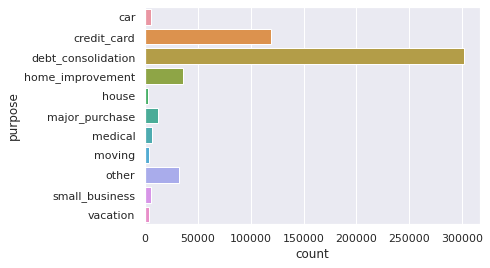

<AxesSubplot:xlabel='count', ylabel='emp_length'>

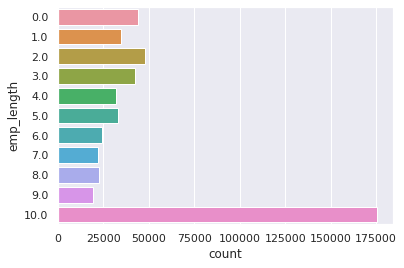

In [217]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [218]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

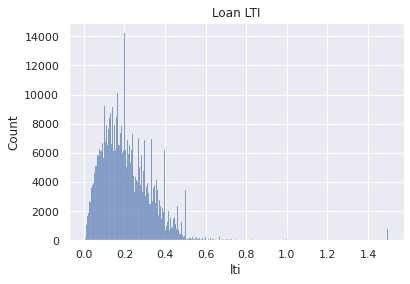

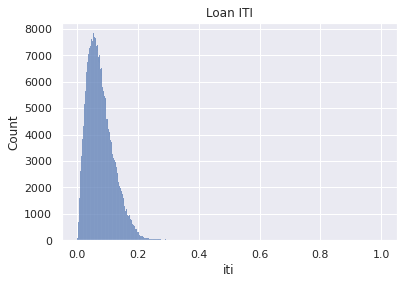

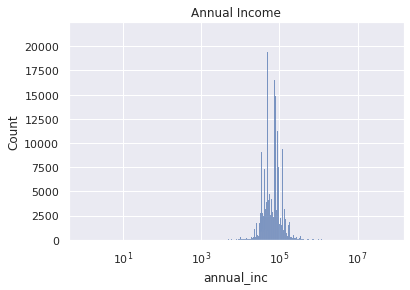

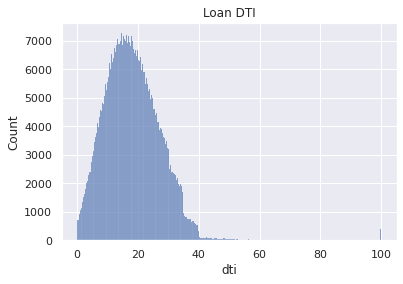

In [219]:
#sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
#plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()
sns.histplot(x='dti', data=df).set(title='Loan DTI')
plt.show()

In [220]:
df.dti.describe()

count    529719.000000
mean         18.282915
std           9.246222
min           0.000000
25%          11.730000
50%          17.540001
75%          24.049999
max         100.000000
Name: dti, dtype: float64

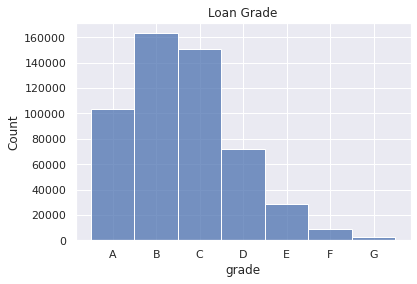

In [221]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')
plt.show()

### EDA with target

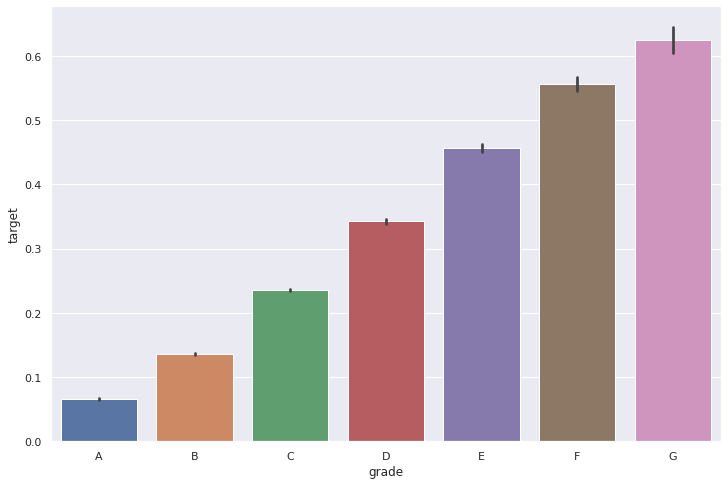

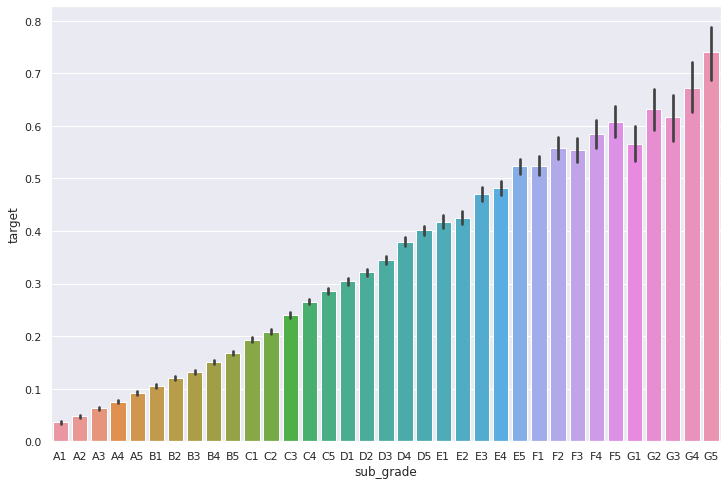

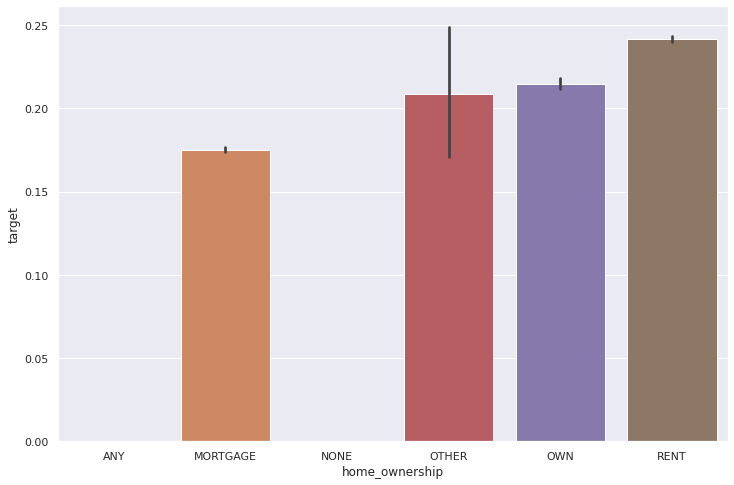

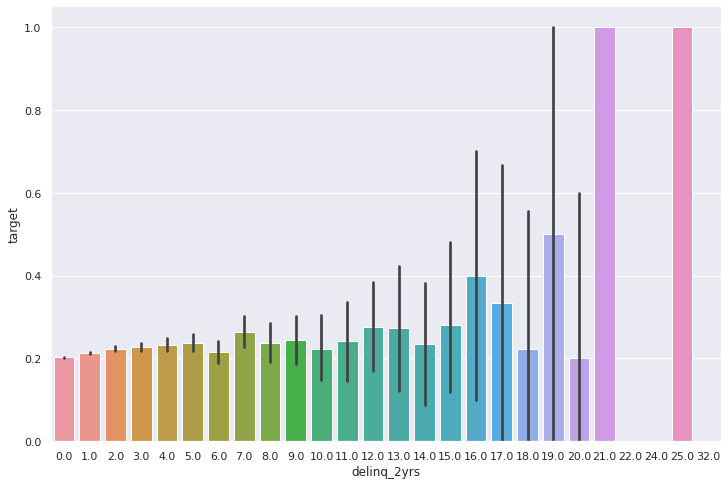

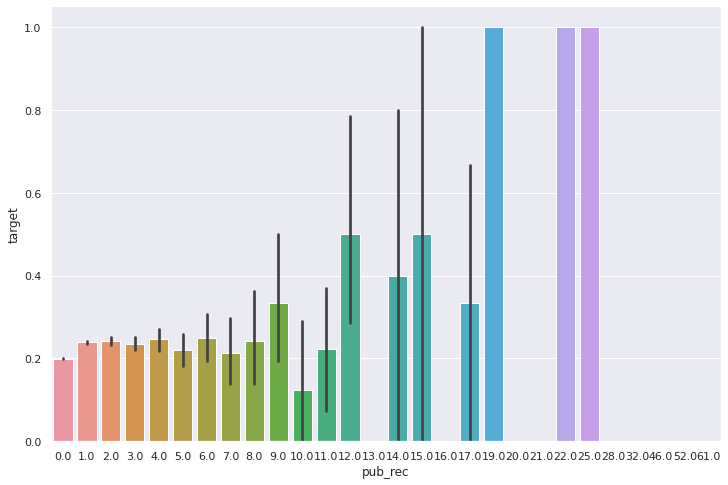

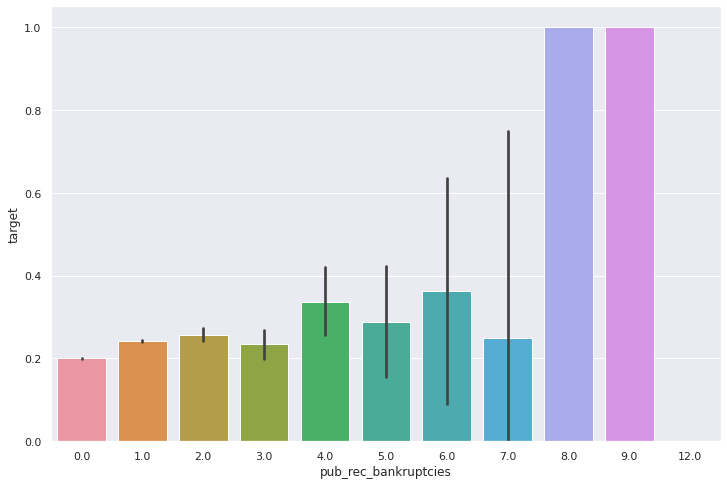

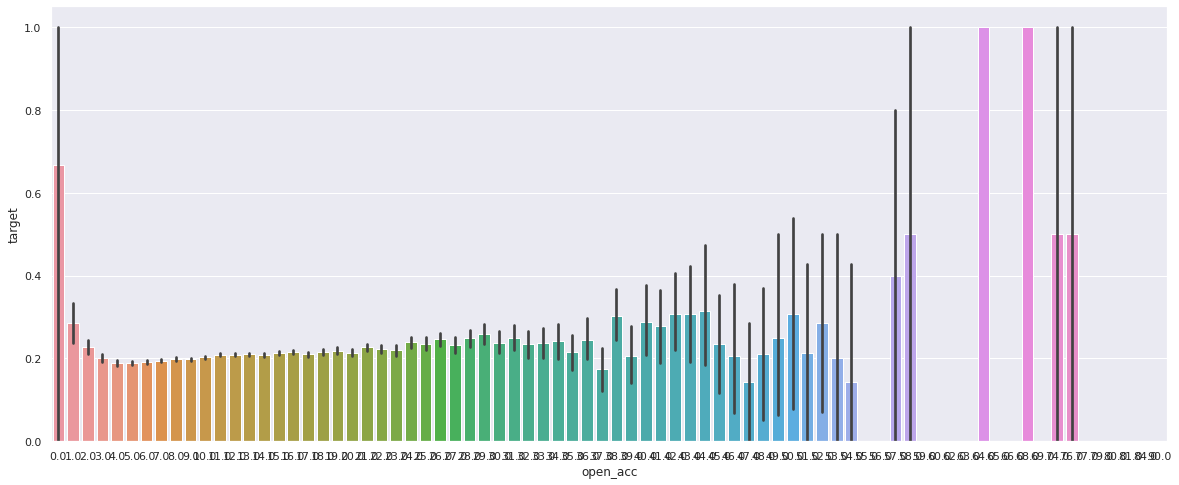

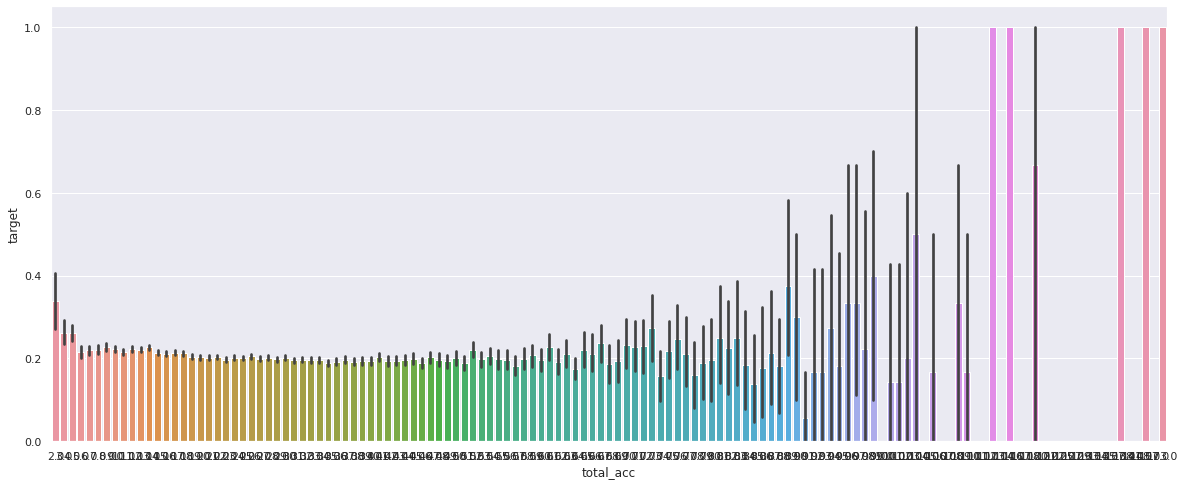

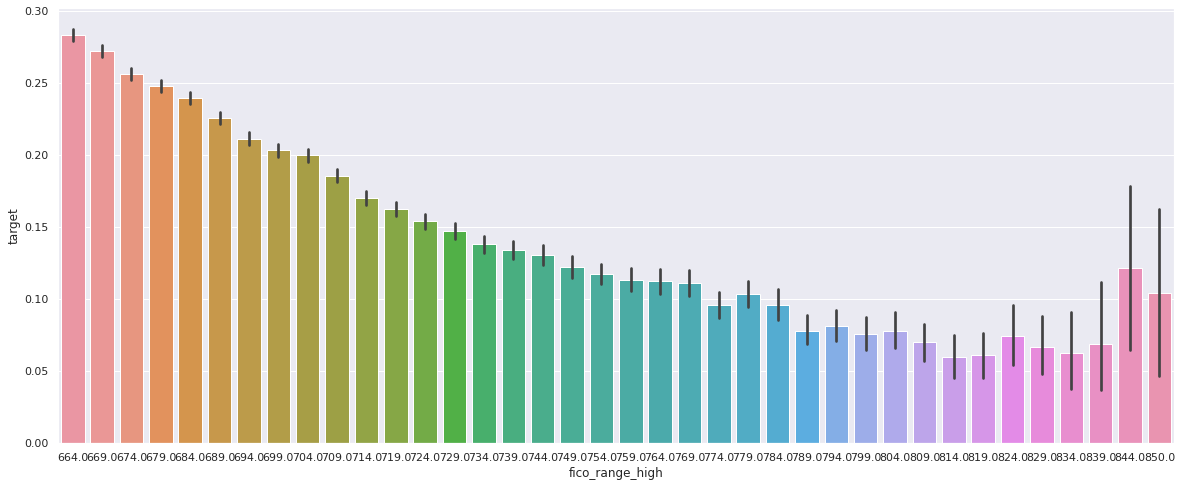

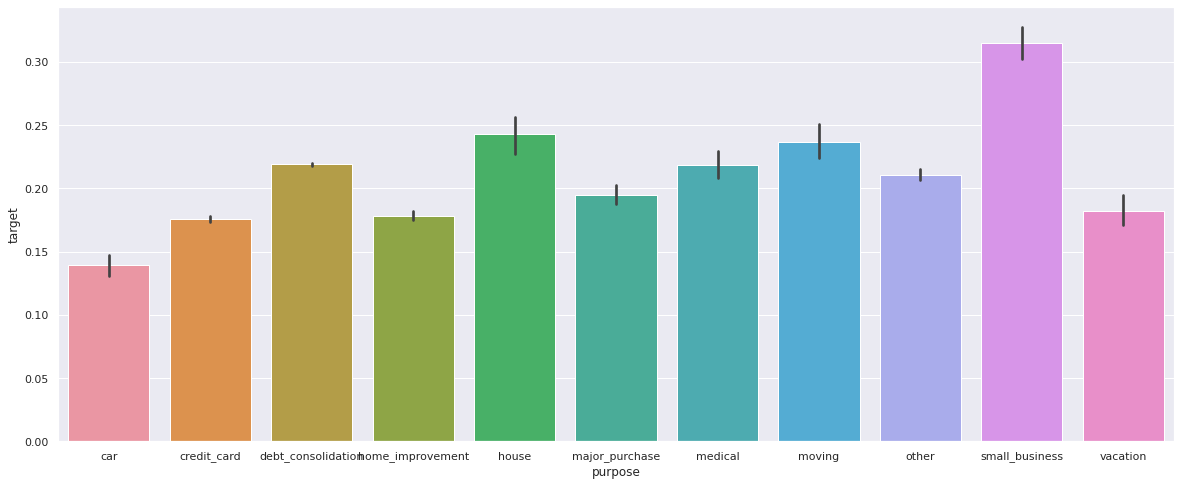

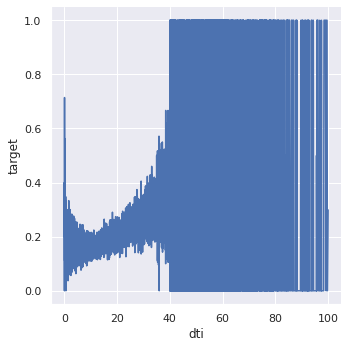

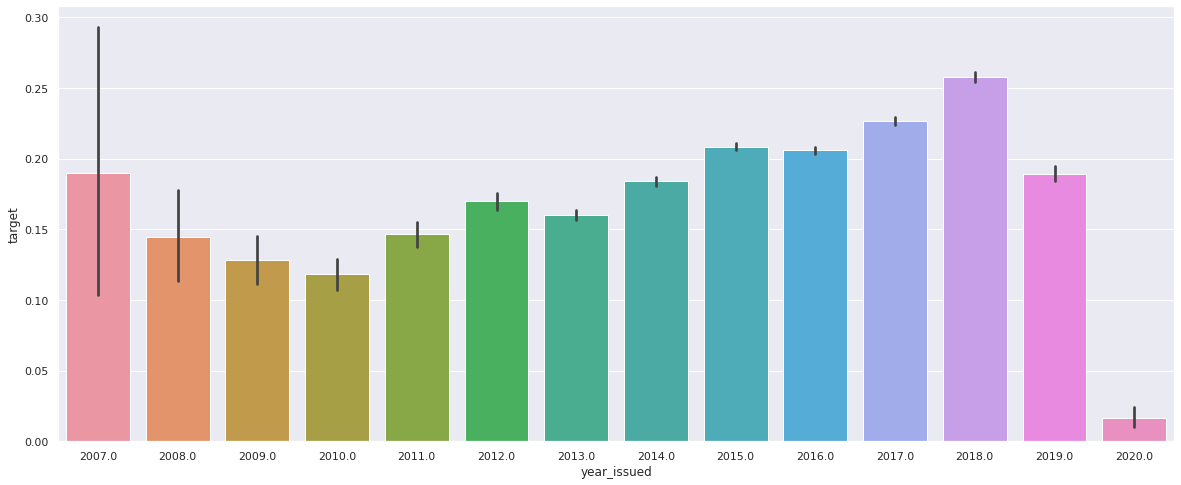

In [222]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()
sns.relplot(x='dti', y='target', data=df, ci=None, kind = 'line')
plt.show()
sns.barplot(x='year_issued', y='target', data=df)
plt.show()

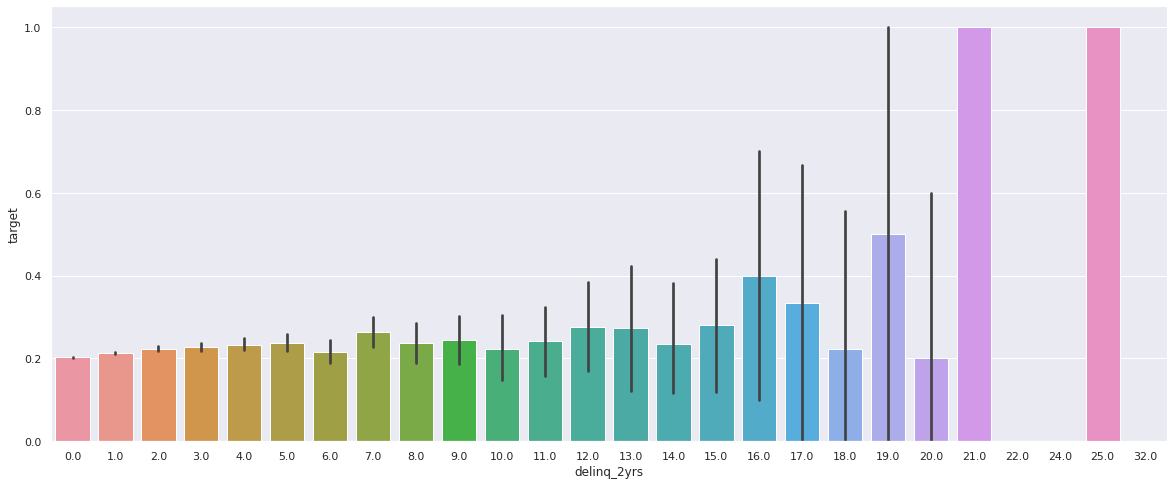

In [223]:
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()

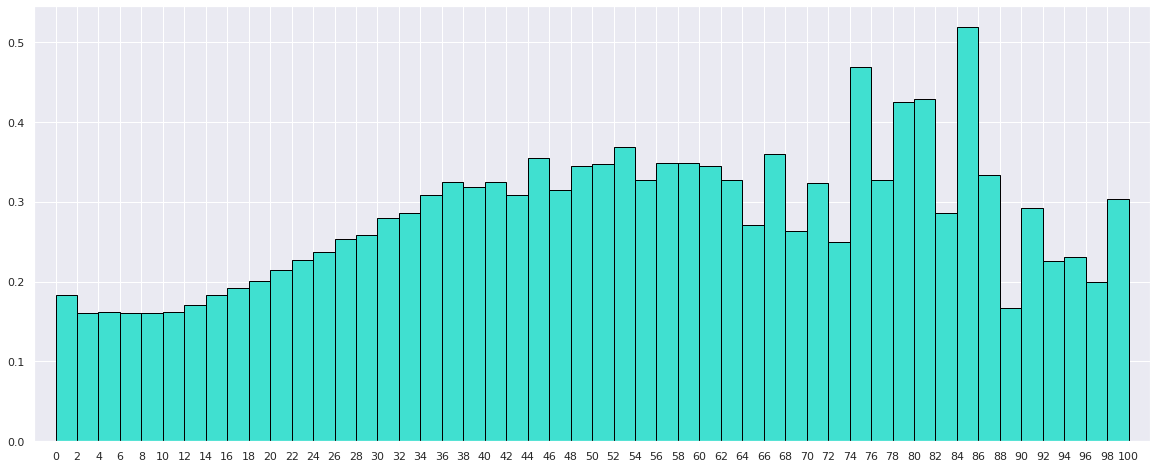

In [224]:
a = df.dti
b = df.target
bins = np.linspace(a.min(), a.max() + 1e-12, 51) # 10 bins, so 11 bin boundaries
c = np.digitize(a, bins)
plt.bar(bins[:-1], [np.mean(b[c == i]) for i in range(1, len(bins))],
        width=bins[1] - bins[0], align='edge', fc='turquoise', ec='black')
plt.xticks(bins)
plt.margins(x=0.02) # smaller margins
plt.show()

### 5. Train-test split, missing values and feature engineering

In this section I fill missing values from train set and encode categorical features.

Depending of feature type, I use three encoding types:

- Target encoding. I do it for feature with more than 5 unique values.
- One-hot encoding. I use it for features with less than 5 unique values.
- Frequency encoding. 'Title' feature only.

In [225]:
display(df.count())

id                                530001
loan_amnt                         530001
funded_amnt                       530001
funded_amnt_inv                   530001
term                              530001
int_rate                          530001
installment                       530001
purpose                           530001
title                             523966
initial_list_status               530001
application_type                  530001
grade                             530001
sub_grade                         530001
fico_range_high                   530001
emp_title                         493640
emp_length                        497639
home_ownership                    530001
annual_inc                        530001
zip_code                          530001
addr_state                        530001
dti                               529719
verification_status               530001
mo_sin_rcnt_tl                    530001
mths_since_last_delinq            530001
mths_since_last_

In [226]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 
                     'total_acc', 'mort_acc', 'pub_rec_bankruptcies', 'bc_open_to_buy','tot_cur_bal_inc', 'total_rev_inc',
                    'total_bal_ex_mort_inc', 'pct_tl_nvr_dlq', 'percent_bc_gt_75']
features_fill_zero = ['open_rv_12m', 'open_il_12m', 'emp_length', 'num_tl_90g_dpd_24m', 
                      'num_tl_30dpd', 'num_tl_120dpd_2m', 'num_accts_ever_120_pd',
                     'acc_open_past_24mths']

for col in features_fill_zero:
    df[col] = df[col].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')
    
test_size = 0.25
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)
test00 = test.copy()
train.drop(columns=['id'],inplace=True)
test.drop(columns=['id'],inplace=True)
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())
    
df['total_cur_bal'] = df.tot_cur_bal_inc.median()*df.annual_inc
df['total_rev_hi_lim'] = df.total_rev_inc.median()*df.annual_inc
df['total_bal_ex_mort'] = df.total_bal_ex_mort_inc.median()*df.annual_inc


display(train.count())

(397501, 77)

(132500, 77)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,2400.0,2400.0,2400.0,36.0,15.96,84.330002,small_business,real estate business,f,Individual,C,C5,739.0,MISSING,10.0,RENT,12252.0,606,IL,8.72,Not Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,2.0,0.0,NaN,10.0,NaN,NaN,2956.0,98.5,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,10.080974,0.0,0.0,0.195886,0.082595,0,0.241267,NaN,NaN,NaN,NaN,0,0.200000,0
1,5600.0,5600.0,5600.0,60.0,21.28,152.389999,small_business,Expand Business & Buy Debt Portfolio,f,Individual,F,F2,679.0,MISSING,4.0,OWN,40000.0,958,CA,5.55,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,11.0,0.0,NaN,13.0,NaN,NaN,5210.0,32.6,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,7.666140,0.0,1.0,0.140000,0.045717,0,0.130250,NaN,NaN,NaN,NaN,0,0.846154,0
2,12000.0,12000.0,12000.0,36.0,12.69,402.540009,debt_consolidation,Consolidation,f,Individual,B,B5,679.0,UCLA,10.0,OWN,75000.0,913,CA,10.78,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12.0,0.0,NaN,34.0,NaN,NaN,23336.0,67.1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,22.166095,0.0,0.0,0.160000,0.064406,0,0.311147,NaN,NaN,NaN,NaN,0,0.352941,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt
0,8000.0,8000.0,8000.0,36.0,7.35,248.300003,credit_card,Credit card refinancing,w,Individual,A,A4,734.0,Membership Specialist,0.0,RENT,27456.0,410,KY,22.639999,Source Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,2.0,4.0,8.0,2.0,2.0,13.0,3799.0,30389.0,8431.0,23.6,19069.0,11.0,4.0,7.0,35800.0,0.0,0.0,0.0,0.0,0.0,30389.0,0.0,0.0,0.0,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018.0,2.0,2018.0,6.001492,0.0,0.0,0.291375,0.108523,0,0.307073,0.138367,1.106825,1.106825,1.303904,0,0.615385,0
1,6100.0,6100.0,6100.0,36.0,17.27,218.309998,debt_consolidation,MISSING,w,Individual,D,D3,699.0,MISSING,0.0,MORTGAGE,17000.0,383,TN,31.639999,Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,2.0,9.0,4.0,0.0,14.0,829.0,7460.0,5373.0,30.0,9542.0,3.0,7.0,8.0,17900.0,0.0,0.0,0.0,0.0,0.0,7460.0,0.0,0.0,0.0,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2016.0,1.0,2016.0,6.083629,0.0,0.0,0.358824,0.154101,0,0.316059,0.048765,0.438824,0.438824,1.052941,0,0.642857,0
2,5000.0,5000.0,5000.0,36.0,12.99,168.449997,debt_consolidation,Debt consolidation,w,Individual,C,C1,704.0,a/r coordinator,10.0,MORTGAGE,44000.0,853,AZ,4.830000,Not Verified,1.0,42.0,1200.0,1200.0,1200.0,1200.0,3.0,3.0,0.0,0.0,8.0,4.0,2.0,28.0,11901.0,95204.0,1030.0,15.1,NaN,1.0,2.0,4.0,6800.0,0.0,0.0,0.0,0.0,0.0,8660.0,1456.0,0.0,NaN,96.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,7.0,2014.0,11.000910,0.0,0.0,0.113636,0.045941,0,0.023409,0.270477,2.163727,0.196818,0.154545,0,0.285714,0


loan_amnt                         397501
funded_amnt                       397501
funded_amnt_inv                   397501
term                              397501
int_rate                          397501
installment                       397501
purpose                           397501
title                             397501
initial_list_status               397501
application_type                  397501
grade                             397501
sub_grade                         397501
fico_range_high                   397501
emp_title                         397501
emp_length                        397501
home_ownership                    397501
annual_inc                        397501
zip_code                          397501
addr_state                        397501
dti                               397501
verification_status               397501
mo_sin_rcnt_tl                    397501
mths_since_last_delinq            397501
mths_since_last_major_derog       397501
mths_since_last_

In [227]:
train.percent_bc_gt_75.describe()

count    397501.000000
mean         42.619877
std          35.493839
min           0.000000
25%           0.000000
50%          40.000000
75%          66.699997
max         100.000000
Name: percent_bc_gt_75, dtype: float64

### Categorical features encoding

In [228]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

freq_enc = (train.groupby('title').size()) / len(train)
train['title_fencoded'] = train['title'].apply(lambda x : freq_enc[x])
test['title_fencoded'] = test['title'].apply(lambda x : freq_enc[x])

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

108.59875416755676

11.563103437423706

(397501, 78)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,2400.0,2400.0,2400.0,36.0,15.96,84.330002,f,Individual,739.0,10.0,12252.0,8.72,Not Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,10.0,NaN,NaN,2956.0,98.5,5311.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,10.080974,0.0,0.0,0.195886,0.082595,0,0.241267,NaN,1.26823,0.561381,0.38505,0,0.200000,0,0.000003,0.277161,0.280321,0.306806,0.204602,0.166976,0.179786,0.230713,0.242775
1,5600.0,5600.0,5600.0,60.0,21.28,152.389999,f,Individual,679.0,4.0,40000.0,5.55,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,11.0,0.0,1.0,13.0,NaN,NaN,5210.0,32.6,5311.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,7.666140,0.0,1.0,0.140000,0.045717,0,0.130250,NaN,1.26823,0.561381,0.38505,0,0.846154,0,0.000003,0.576343,0.280321,0.306806,0.204602,0.214971,0.207226,0.578284,0.210446
2,12000.0,12000.0,12000.0,36.0,12.69,402.540009,f,Individual,679.0,10.0,75000.0,10.78,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,0.0,0.0,0.0,12.0,0.0,1.0,34.0,NaN,NaN,23336.0,67.1,5311.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,22.166095,0.0,0.0,0.160000,0.064406,0,0.311147,NaN,1.26823,0.561381,0.38505,0,0.352941,0,0.002976,0.162431,0.204602,0.219412,0.217460,0.204347,0.207226,0.133374,0.210446
3,3000.0,3000.0,3000.0,36.0,9.91,96.680000,f,Individual,709.0,3.0,15000.0,12.56,Source Verified,120.0,1200.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,11.0,0.0,1.0,11.0,NaN,NaN,7323.0,43.1,5311.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,8.419064,0.0,0.0,0.200000,0.077344,0,0.488200,NaN,1.26823,0.561381,0.38505,0,1.000000,0,0.000003,0.099909,0.204602,0.173934,0.204602,0.166976,0.179786,0.133374,0.242775
4,10000.0,10000.0,10000.0,36.0,15.27,347.980011,f,Individual,674.0,4.0,42000.0,18.60,Not Verified,120.0,61.0,1200.0,1200.0,1200.0,1200.0,0.0,2.0,0.0,0.0,14.0,0.0,1.0,28.0,NaN,NaN,24043.0,70.2,5311.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,40.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,2011.0,12.0,2011.0,13.166595,0.0,0.0,0.238095,0.099423,0,0.572452,NaN,1.26823,0.561381,0.38505,0,0.500000,0,0.000146,0.260706,0.204602,0.178431,0.186002,0.236854,0.207226,0.230713,0.242775


loan_amnt                         397501
funded_amnt                       397501
funded_amnt_inv                   397501
term                              397501
int_rate                          397501
installment                       397501
initial_list_status               397501
application_type                  397501
fico_range_high                   397501
emp_length                        397501
annual_inc                        397501
dti                               397501
verification_status               397501
mo_sin_rcnt_tl                    397501
mths_since_last_delinq            397501
mths_since_last_major_derog       397501
mths_since_last_record            397501
mths_since_recent_bc_dlq          397501
mths_since_recent_revol_delinq    397501
num_tl_op_past_12m                397501
inq_last_6mths                    397501
inq_fi                            397501
inq_last_12m                      397501
open_acc                          397501
acc_open_past_24

In [229]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore", drop='if_binary'), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
X_train.columns = X_train.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
X_test.columns = X_test.columns.str.replace(r'^cat__', '').str.replace(r'^remainder__', '')
#X_train.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_train.columns]
#X_test.columns = [x.strip_prefix('remainder__').strip_prefix('cat__') for x in X_test.columns]

print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()
X_test_0 = X_test.copy()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,initial_list_status,application_type,fico_range_high,emp_length,annual_inc,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,bc_open_to_buy,mo_sin_rcnt_rev_tl_op,num_actv_rev_tl,num_op_rev_tl,total_rev_hi_lim,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,total_bal_ex_mort,tot_coll_amt,tax_liens,percent_bc_gt_75,pct_tl_nvr_dlq,open_rv_12m,open_il_12m,num_tl_90g_dpd_24m,num_tl_30dpd,num_tl_120dpd_2m,num_accts_ever_120_pd,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,total_bal_ex_mort_inc,total_rev_inc,low_fico,open_cl_ratio,was_bankrupt,title_fencoded,sub_grade_encoded,emp_title_encoded,purpose_encoded,title_encoded,zip_code_encoded,addr_state_encoded,grade_encoded,home_ownership_encoded
0,8000.0,8000.0,8000.0,36.0,7.35,248.300003,w,Individual,734.0,0.0,27456.0,22.639999,Source Verified,1.0,1200.0,1200.0,1200.0,1200.0,1200.0,2.0,0.0,2.0,4.0,8.0,2.0,2.0,13.0,3799.0,30389.0,8431.0,23.6,19069.0,11.0,4.0,7.0,35800.0,0.0,0.0,0.0,0.0,0.0,30389.0,0.0,0.0,0.000000,100.000000,1.0,1.0,0.0,0.0,0.0,0.0,2018.0,2.0,2018.0,6.001492,0.000000,0.291375,0.108523,0,0.307073,0.138367,1.106825,1.106825,1.303904,0,0.615385,0,0.199343,0.077561,0.191685,0.174936,0.179860,0.219247,0.214587,0.065839,0.242349
1,6100.0,6100.0,6100.0,36.0,17.27,218.309998,w,Individual,699.0,0.0,17000.0,31.639999,Verified,3.0,1200.0,1200.0,1200.0,1200.0,1200.0,3.0,0.0,0.0,2.0,9.0,4.0,0.0,14.0,829.0,7460.0,5373.0,30.0,9542.0,3.0,7.0,8.0,17900.0,0.0,0.0,0.0,0.0,0.0,7460.0,0.0,0.0,0.000000,100.000000,2.0,1.0,0.0,0.0,0.0,0.0,2016.0,1.0,2016.0,6.083629,0.000000,0.358824,0.154101,0,0.316059,0.048765,0.438824,0.438824,1.052941,0,0.642857,0,0.011492,0.345145,0.284011,0.219456,0.267177,0.313922,0.212979,0.341403,0.175150
2,5000.0,5000.0,5000.0,36.0,12.99,168.449997,w,Individual,704.0,10.0,44000.0,4.830000,Not Verified,1.0,42.0,1200.0,1200.0,1200.0,1200.0,3.0,3.0,0.0,0.0,8.0,4.0,2.0,28.0,11901.0,95204.0,1030.0,15.1,5311.0,1.0,2.0,4.0,6800.0,0.0,0.0,0.0,0.0,0.0,8660.0,1456.0,0.0,40.000000,96.300003,0.0,0.0,0.0,0.0,0.0,0.0,2014.0,7.0,2014.0,11.000910,0.000000,0.113636,0.045941,0,0.023409,0.270477,2.163727,0.196818,0.154545,0,0.285714,0,0.501649,0.193681,0.205730,0.219456,0.225362,0.204741,0.202401,0.236019,0.175150
3,25000.0,25000.0,25000.0,60.0,12.69,564.869995,w,Individual,734.0,10.0,85000.0,23.030001,Source Verified,1.0,18.0,1200.0,1200.0,18.0,18.0,3.0,0.0,0.0,0.0,14.0,4.0,2.0,32.0,4068.0,56952.0,14285.0,29.5,22584.0,1.0,9.0,11.0,48500.0,1.0,0.0,0.0,0.0,0.0,56952.0,0.0,0.0,11.100000,96.900002,0.0,0.0,0.0,0.0,0.0,0.0,2015.0,4.0,2015.0,22.497382,0.000000,0.294118,0.079746,0,0.168059,0.047859,0.670024,0.670024,0.570588,0,0.437500,0,0.199343,0.210260,0.205730,0.174936,0.179860,0.230393,0.206870,0.236019,0.175150
4,12000.0,12000.0,12000.0,60.0,12.69,271.140015,w,Individual,674.0,10.0,120000.0,11.070000,Not Verified,7.0,62.0,62.0,36.0,62.0,62.0,3.0,0.0,0.0,0.0,14.0,7.0,8.0,33.0,7360.0,103046.0,9226.0,49.8,9874.0,8.0,5.0,11.0,20200.0,0.0,0.0,0.0,2.0,2.0,103046.0,0.0,0.0,22.200001,95.800003,0.0,0.0,0.0,0.0,0.0,5.0,2015.0,5.0,2015.0,16.495890,0.121242,0.100000,0.027114,0,0.076883,0.061333,0.858717,0.858717,0.168333,0,0.424242,1,0.501649,0.210260,0.177460,0.219456,0.225362,0.169332,0.179321,0.236019,0.175150


Number of features before transaformation:  (397501, 77)
time to do feature proprocessing:  13.126683473587036
Number of features after transaformation:  (397501, 79)


### 6. Modeling

Here I will build 2 models to predict loan bankruptcies:

- Baseline XGBoost model (default hyperparameters).
- XGBoost model with hyperparameter optimization using Optuna.

'Train Accuracy: '

0.8271652146787052

'F1 score: '

0.3955906675581518

'ROCAUC: '

0.6225660684212797

'PRAUC: '

0.5627081785453855

'R20P: '

0.7581781113891206

'Test Accuracy: '

0.8145283018867925

'F1 score: '

0.3374046213162933

'ROCAUC: '

0.5977442492413098

'PRAUC: '

0.48410178058026926

'R20P: '

0.6452304394426581

10.03092908859253

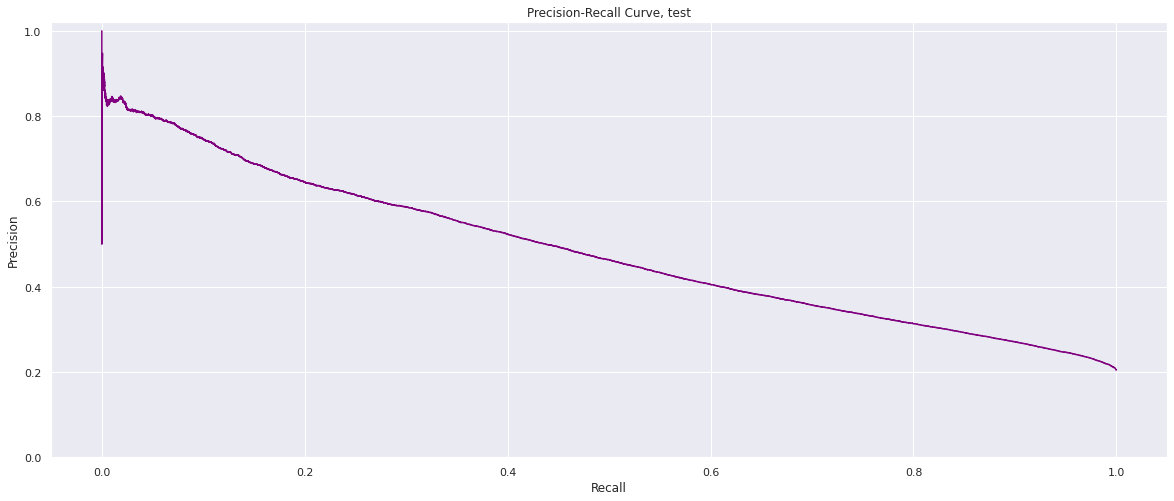

In [230]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

[I 2022-08-14 20:32:20,917] A new study created in memory with name: no-name-42d5004e-f325-48dd-a56c-7779acd11d2f
[I 2022-08-14 20:32:50,033] Trial 0 finished with value: 0.48896530624483225 and parameters: {'n_estimators': 1219, 'max_depth': 4, 'learning_rate': 0.030753288339211652, 'colsample_bytree': 0.3575338654461455, 'subsample': 0.9371089260490348, 'alpha': 1.7896368861867396, 'lambda': 0.4043601268368519, 'gamma': 7.120887960970025e-05, 'min_child_weight': 3.0933054846172365}. Best is trial 0 with value: 0.48896530624483225.
[I 2022-08-14 20:33:11,045] Trial 1 finished with value: 0.4884905382989726 and parameters: {'n_estimators': 1179, 'max_depth': 2, 'learning_rate': 0.13306404251896134, 'colsample_bytree': 0.5358861798893246, 'subsample': 0.9037231431323312, 'alpha': 5.4950691109869, 'lambda': 18.228983455207363, 'gamma': 3.5835658690021675e-10, 'min_child_weight': 0.10391214618355178}. Best is trial 0 with value: 0.48896530624483225.
[I 2022-08-14 20:33:22,676] Trial 2 fin

Total time for hypermarameter optimization  1181.4587616920471
        n_estimators : 912
           max_depth : 4
       learning_rate : 0.06384769196868269
    colsample_bytree : 0.8711044533649013
           subsample : 0.948371960527022
               alpha : 1.8237064583920597
              lambda : 44.56024343170796
               gamma : 0.00020613506629471422
    min_child_weight : 4.912098782913259
best objective value : 0.48943768250505204


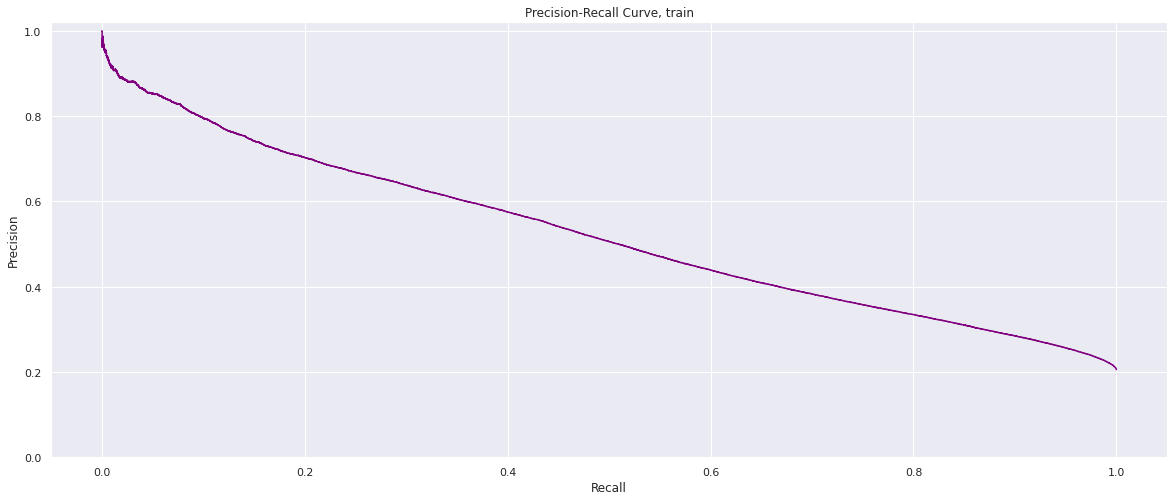

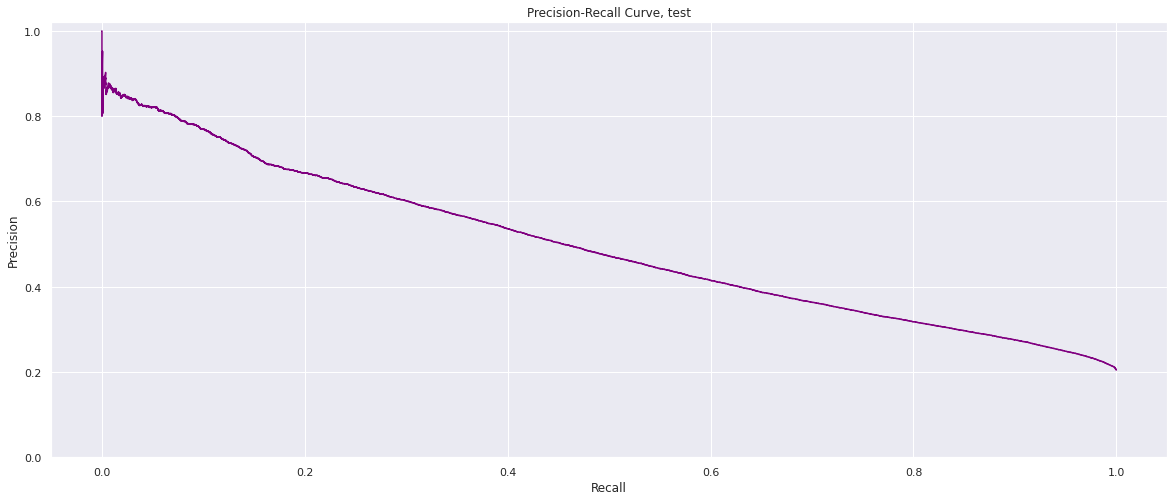

'Train Accuracy: '

0.8199274970377433

'F1 score: '

0.35676093422838095

'ROCAUC: '

0.6060811920586948

'PRAUC: '

0.5225680115980069

'R20P: '

0.7031559033450856

'Test Accuracy: '

0.8167849056603773

'F1 score: '

0.3399314807765512

'ROCAUC: '

0.5990807200080961

'PRAUC: '

0.4955144896153669

'R20P: '

0.6670764691418736

'Time to do hyperparameter optimization: '

1221.7580676078796

In [231]:
### Fit XGBoost using Optuna hyperparameter optimization ###

time1 = time.time()

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=2):

    cv_regularizer=0.01
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 500, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 6),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.25),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict_proba(X_B)[:, 1]
            #y_pred_train[train_index] += model.predict_proba(X_A)[:, 1]
                      
        #precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred_train)
        #score_train = auc(recall_t, precision_t)
        precision_t, recall_t, threshold = precision_recall_curve(y_train, y_pred)
        score_test = auc(recall_t, precision_t)
            
        #score_train = roc_auc_score(y_train, y_pred_train)
        #score_test = roc_auc_score(y_train, y_pred) 
        #overfit = score_train-score_test
        #temp_out.append(score_test-cv_regularizer*overfit)
        temp_out.append(score_test)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, train')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

fig, ax = plt.subplots()
ax.plot(recall_t, precision_t, color='purple')
ax.set_title('Precision-Recall Curve, test')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_ylim(bottom=0, top=1.02)
plt.show()

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display('Time to do hyperparameter optimization: ', time.time()-time1)

### 7. Model interpretation

In [232]:
#results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
#fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
#fi = fi.sort_values('FI', ascending = False)

#display(fi)

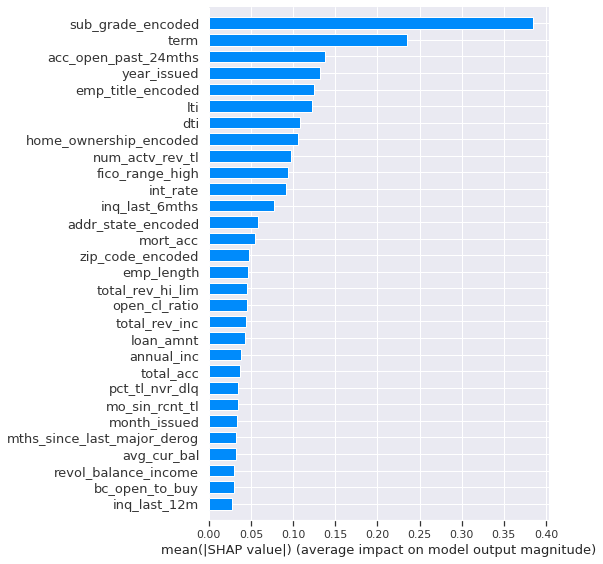

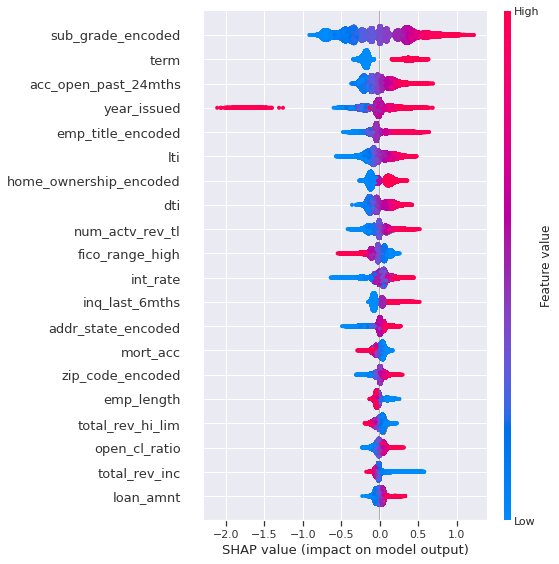

In [233]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
#display(feature_importance)

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)
shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [234]:
#indx = 1
#fig = plt.subplots(figsize=(6,6),dpi=200)
#ax_2= shap.decision_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[indx],link= "logit")

#shap.initjs()
#shap.force_plot(explainerxgbc.expected_value, shap_values_XGBoost_test[indx], X_test.iloc[[indx]],link= "logit")

In [235]:
time.time()-time0

1397.6305401325226

### 8. Business implications

#### 8.1 Is this model useful?

This project is a perfect illustration of how machine learning can create value if we think hard about business problem at hand rather than focusing on a few narrow model evaluation metrics.

If you view this project as a purely data mining/prediction exercise, then it is arguably a failure. Model accuracy is 81% which barely beats 80% from a trivial model, always predicting no default. F1 score is only 34%, which is not impressive. ROCAUC is 59% which is not much better than a random guess.

However, the predictive model above can create value if used properly. Let me show how.

Precision-recall curve above shows that model is actually very good in predicting defaults for around one quarter of defaulted loans. For example, its precision at 20% recall is 69%. This means that if we use the model only to predict default for those loans it is most confident about, we can avoid at least 20% of credit losses while forgoing relatively few profitable lending opportunities. 

#### 8.2 How much value does it create?

To quantify value created by the model, I consider a problem faced by all Lending Club investors as a group to maximize their investment profit. They can do so by avoiding x% of the riskiest loans as determined by my model. In order to keep this analysis simple and accessible to wider audience I abstract away from time discounting, compound interest and present value calculations. All the calculations below assume simple interest.

The decision of an investor to avoid financing x% of the riskiest loans is a tradoeff between a foregone interest income and a credit loss. 

If investors invest in a loan:
- They receive interest income in the future as long as the borrower repays a loan.
- They suffer credit losses and receive only recovered amount if the borrower defaults.

So their total dollar return (TR) from investment is as follows:

$$ TR_{Invest} = \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k.$$

Their outisde riskless option is to invest in Treasury bills with similar maturity. Average yield of 3-year treasury notes over this sample period [is around 2%](https://fred.stlouisfed.org/series/DGS3). So their TR if they forgo such loans is:

$$ TR_{Forgo} = \sum_{i \in AllLoans} LoanAmount_i*(1.02).$$

Thus the decision to issue such loans depends on which part dominates. Savings of investors from avoiding top x% riskiest loans are the difference between the returns fom investing in T-notes and LendingClub loans:

$$ \sum_{i \in AllLoans} LoanAmount_i*(1.02) - \sum_{j \in RepaidLoans}LoanAmount_j*(r_j+1) + \sum_{k \in DefaultedLoans}Recovery_k $$

The expression above is the value created from avoiding the riskiest loans. For example, if I use the model to identify top 20% riskiest loans, then AllLoans will be the loans with 20% of the highest predicted default probabilities. RepaidLoans and DefaultedLoans will be subsets of those loans.

The code below uses loan_amnt, int_rate and recovery features to calculate this value created.



In [236]:
recoveries['total_recovery'] = recoveries.total_rec_prncp + recoveries.total_rec_int + recoveries.recoveries
recoveries['tot_recov_rp'] = recoveries.total_recovery/recoveries.loan_amnt
recoveries['tot_recov_rt'] = recoveries.total_recovery/(recoveries.loan_amnt*((recoveries.int_rate/100+1)**3))
# in a few cases the recoveries seem to exceed total proceeds.
# this may be the result of ignoring time discounting and compound interest in my calculations
# ior those may be rarer 60-months loans. so i do not adjust such cases.
display(recoveries.describe(), recoveries.head())

,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
count,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000,109085.000000
mean,1367.722534,15871.564453,15.650086,4618.821777,2792.090820,8778.634766,0.562341,0.368011
std,2009.665771,9072.825195,5.027926,4380.201660,2847.963135,7124.014648,0.293171,0.196640
min,0.000000,1000.000000,5.310000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,9300.000000,11.990000,1586.069946,873.750000,3684.020020,0.333000,0.212242
50%,720.330017,14600.000000,14.990000,3291.959961,1856.170044,6859.430176,0.525157,0.340963
75%,1896.729980,21000.000000,18.550000,6198.540039,3728.580078,11852.330078,0.769617,0.508548
max,39859.550781,40000.000000,30.990000,38694.070312,28005.960938,61740.929688,1.764027,1.090076


,id,loan_status,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
8,1071795,Charged Off,190.539993,5600.0,21.28,162.020004,294.940002,647.500000,0.115625,0.064816
21,1039153,Charged Off,9.200000,21000.0,12.42,10694.959961,3330.439941,14034.600586,0.668314,0.470381
24,1069559,Charged Off,275.019989,6000.0,11.71,1305.579956,475.250000,2055.849854,0.342642,0.245790
27,1069657,Charged Off,263.000000,5000.0,16.77,629.049988,719.109985,1611.159912,0.322232,0.202383
50,1069248,Charged Off,222.809998,15000.0,9.91,13556.450195,2374.340088,16153.599609,1.076907,0.811085


In [237]:
X_test = X_test_0.copy()
test = X_test[['loan_amnt', 'int_rate']]
test.int_rate = test.int_rate/100+1
test['y_pred'] = optuna_xgb.predict_proba(X_test)[:,1]
test['id'] = test00.id
test['y'] = y_test
test = pd.merge(test, recoveries[['id', 'loan_amnt', 'int_rate', 'total_recovery']], on='id', how = 'left')
display(recoveries.head(), test.head())
display(test.loc[test.y==0].count(), test.loc[test.y==1].count())

,id,loan_status,recoveries,loan_amnt,int_rate,total_rec_prncp,total_rec_int,total_recovery,tot_recov_rp,tot_recov_rt
8,1071795,Charged Off,190.539993,5600.0,21.28,162.020004,294.940002,647.500000,0.115625,0.064816
21,1039153,Charged Off,9.200000,21000.0,12.42,10694.959961,3330.439941,14034.600586,0.668314,0.470381
24,1069559,Charged Off,275.019989,6000.0,11.71,1305.579956,475.250000,2055.849854,0.342642,0.245790
27,1069657,Charged Off,263.000000,5000.0,16.77,629.049988,719.109985,1611.159912,0.322232,0.202383
50,1069248,Charged Off,222.809998,15000.0,9.91,13556.450195,2374.340088,16153.599609,1.076907,0.811085


,loan_amnt_x,int_rate_x,y_pred,id,y,loan_amnt_y,int_rate_y,total_recovery
0,8000.0,1.0735,0.100256,126294042,0.0,NaN,NaN,NaN
1,6100.0,1.1727,0.359375,68635352,0.0,NaN,NaN,NaN
2,5000.0,1.1299,0.117403,20006803,0.0,NaN,NaN,NaN
3,25000.0,1.1269,0.233451,46886508,0.0,NaN,NaN,NaN
4,12000.0,1.1269,0.150345,47008266,0.0,NaN,NaN,NaN


loan_amnt_x       105383
int_rate_x        105383
y_pred            105383
id                105383
y                 105383
loan_amnt_y            0
int_rate_y             0
total_recovery         0
dtype: int64

loan_amnt_x       27117
int_rate_x        27117
y_pred            27117
id                27117
y                 27117
loan_amnt_y       27117
int_rate_y        27117
total_recovery    27117
dtype: int64

In [252]:
# select riskiest loans by calculating decision threshold, giving 20% recall:

desired_recall = 0.2

temp = recall_t[(recall_t>(desired_recall-0.001))&(recall_t<(desired_recall+0.001))]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20threshold = threshold[indexx]
p80risk = r20threshold
test['p80risk'] = (test.y_pred>=p80risk).astype(int)
display(test.shape, p80risk)

risky_loans = test[test.p80risk==1]
risky_loans.loc[risky_loans.total_recovery.isnull(),'total_recovery']=\
risky_loans.loan_amnt_x*(risky_loans.int_rate_x**3)
# when the loan is repaid, I calculate total return and save it into total_recovery column.
display(risky_loans.head(), risky_loans.shape)

proceeds = risky_loans.total_recovery.sum()
proceeds_tnotes = (risky_loans.loan_amnt_x.sum())*(1.02**3)
print("Investors' total returns from investing in risky loans", int(proceeds))
print("Investors' total returns from investing in T-notes", int(proceeds_tnotes))
print("Investors' savings: $", int(proceeds_tnotes-proceeds))
estimated_savings = (proceeds_tnotes-proceeds)*3.3*4
print("Estimated investors' savings from all LendingClub loans: $", estimated_savings)


# In this particular sample, the savings are maximized at 22.2% recall threshold.
# Then the saving for investors will be $22.089M.

(132500, 9)

0.53141075

,loan_amnt_x,int_rate_x,y_pred,id,y,loan_amnt_y,int_rate_y,total_recovery,p80risk
66,12775.0,1.1999,0.540533,57356748,1.0,12775.0,19.99,8029.359863,1
72,23975.0,1.1786,0.565598,42354492,0.0,NaN,NaN,39251.652344,1
82,35000.0,1.2145,0.855197,126594328,1.0,35000.0,21.45,21301.980469,1
96,32350.0,1.2388,0.837224,120113834,1.0,32350.0,23.88,12785.799805,1
103,19200.0,1.2630,0.839588,111531774,1.0,19200.0,26.30,6457.990234,1


(8132, 9)

Investors' total returns from investing in risky loans 145470464
Investors' total returns from investing in T-notes 167091656
Investors' savings: $ 21621192
Estimated investors' savings from all LendingClub loans: $ 285399743.29152024


We can see that using this model allows investors in the test sample to save \\$ 21.621M. 
Accounting for 75/25 train-test split and initial 30\% sample from the original dataset, the estimated saving should be $$3.3*4*21.621M = 285.4M$$.

The takeaway is that we do not necessrily need ML model with superior predictive performance over the whole feature space. As long as ML model performs well on a subset of instances, it can create great value if used properly.
